## 任务1：报名比赛，下载比赛数据集并完成读取

- 步骤1 ：登录&报名比赛：https://aistudio.baidu.com/aistudio/competition/detail/45/0/task-definition
- 步骤2 ：下载比赛数据集
- 步骤3 ：使用Pandas完成数据读取。

In [1]:
import numpy as np 
import pandas as pd 
import os
import gc
import matplotlib.pyplot as plt
import jieba
import distance 
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()
pd.__version__

'1.3.5'

In [2]:
# data_dir = 'D:/study_hard/statistic/千言数据集'
data_list = ['bq_corpus','lcqmc','paws-x-zh']
data_dir = 'E:/学习/千言数据集/'

In [3]:
# 先读一个数据集，后面统一读

train = pd.read_csv(data_dir+'/bq_corpus/train.tsv',sep='\t',error_bad_lines=False,names=['q1','q2','label']).dropna()
test = pd.read_csv(data_dir+'/bq_corpus/test.tsv',sep='\t',error_bad_lines=False,names=['q1','q2']).dropna()
test['label'] = -1 
dev = pd.read_csv(data_dir+'/bq_corpus/dev.tsv',sep='\t',error_bad_lines=False,names=['q1','q2','label']).dropna()

train.head(),train.shape()

E:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


(                            q1                q2 label
 0             用微信都6年，微信没有微粒贷功能          4。号码来微粒贷     0
 1                       微信消费算吗           还有多少钱没还     0
 2         交易密码忘记了找回密码绑定的手机卡也掉了  怎么最近安全老是要改密码呢好麻烦     0
 3  你好我昨天晚上申请的没有打电话给我今天之内一定会打吗？          什么时候可以到账     0
 4                      “微粒贷开通"   你好，我的微粒贷怎么没有开通呢     0,
 (86198, 3))

## 任务2：对句子对提取TFIDF以及统计特征，训练和预测

参考代码：https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
- 步骤1 ：对句子对（句子A和句子B统计）如下特征：
    - 句子A包含的字符个数、句子B包含的字符个数
    - 句子A与句子B的编辑距离
    - 句子A与句子B共有单词的个数
    - 句子A与句子B共有字符的个数
    - 句子A与句子B共有单词的个数 / 句子A字符个数
    - 句子A与句子B共有单词的个数 / 句子B字符个数
- 步骤2 ：计算TFIDF，并对句子A和句子B进行特征转换，并进行
- 步骤3 ：计算句子A与句子B的TFIDF向量的内积距离
- 步骤4 ：将上述特征送入分类模型，训练并预测，将结果预测提交到比赛网站。

In [33]:
# 句子对特征

# 字符个数
train['q1_len'] = train['q1'].apply(len)
train['q2_len'] = train['q2'].apply(len)  

# 编辑距离 
# Levenshtein Distance 被称为编辑距离（Edit Distance），一个度量两个字符序列之间差异的字符串度量标准
train['Lev_distance'] = train.apply(lambda x:distance.levenshtein(x['q1'],x['q2']),axis=1)

# jieba分词 
# cut_all=True，全模式，“我来到北京清华大学”-->“ 我/ 来到/ 北京/ 清华/ 清华大学/ 华大/ 大学”
def jieba_cut(sentence):
    word_list = jieba.lcut(sentence,cut_all=True) 
    return word_list 

train['q1_jieba_cut'] = train['q1'].apply(lambda x:jieba_cut(x)) 
train['q2_jieba_cut'] = train['q2'].apply(lambda x:jieba_cut(x)) 

# 分词后的词个数
train['q1_words_len'] = train['q1_jieba_cut'].apply(len)
train['q2_words_len'] = train['q2_jieba_cut'].apply(len)  
   
# 分词后，两句子相同词占所有词的比例



count    172396.000000
mean         13.847769
std         271.696725
min           1.000000
25%           7.000000
50%          10.000000
75%          14.000000
max       51842.000000
dtype: float64
count    20000.000000
mean        11.861050
std          7.183399
min          1.000000
25%          7.000000
50%         10.000000
75%         14.000000
max        100.000000
dtype: float64


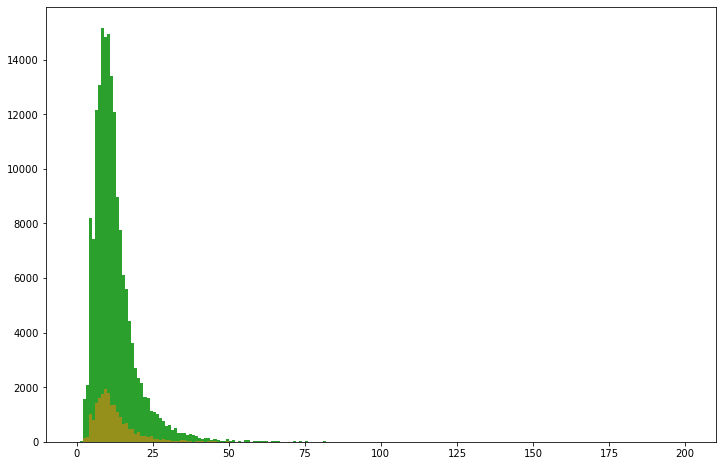

In [19]:
# 字数统计
# 文本长度分布基本一致

train_qs = pd.Series(train['q1'].tolist()+train['q2'].to_list())
test_qs = pd.Series(test['q1'].tolist()+test['q2'].to_list())

train_len = train_qs.apply(len)
test_len = test_qs.apply(len)

print(train_len.describe())
print(test_len.describe())

plt.figure(figsize=(12, 8))
plt.hist(train_len, bins=200, range=[0, 200], color=pal[2], label='train')
plt.hist(test_len, bins=200, range=[0, 200], color=pal[1], alpha=0.5, label='test')
plt.show();

In [20]:
from collections import Counter
# 所有的字符都是以空格分隔
all_lines = ' '.join(list(train['q1']))
# 统计每个字符出现的次数
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d:d[1], reverse = True)
word_count[:10]

[('开通', 69),
 ('开通微粒贷', 49),
 ('借款取消', 44),
 ('如何计息', 34),
 ('4:怎么计息', 33),
 ('如何更改手机', 31),
 ('开通借款', 31),
 ('借款后多长时间给打电话', 30),
 ('借款失败', 30),
 ('开通一下', 30)]